## High Frequency Market Making

### Problem Formulation
The algorithm seeks to optimize the bid ask spread for each time $t \lt T$ such that the net Profit and Loss of trading the spread is maximized at the end of the trading session time $T$. We also want to control the algorithm for excessive risk taking during the trading session. Thus, we impose two penalties: (1) running inventory penalty for trading too large exposures during the trading session, and (2) terminal inventory penalty i.e. holding non-zero inventory at the end of the trading day.  Mathematically, the maximization of stochastic system subject to the penalties is equivalent to maximizing the following objective:

$$
v(S_t, X_t, Q_t, t) = \underset{\delta^{\text{b}}, \delta^{\text{a}}}{max} \ \mathbb{E} \bigg[ X_T + Q_T(S_T - \alpha Q_T) - \phi\sum_{s=t}^{T}Q_s^2 \bigg]
$$

where

- $S_t$ is the mid-price of the asset at time $t$
- $X_t$ is the market maker's cash at time $t$
- $Q_t$ is the market maker's inventory at time $t$
- $\delta^{\text{b}}$ is how deep in the market we quote our bid price
- $\delta^{\text{a}}$ is how deep in the market we quote our ask price
- $\alpha > 0$ is terminal inventory penalty parameter
- $\phi > 0$ is running inventory penalty parameter

Furthermore, this objective can be expressed recursively via the bellman optimality principle:
$$
\begin{align*}
    v(S_t, X_t, Q_t, t) &= \underset{\delta^{\text{b}}, \delta^{\text{a}}}{max} \ \mathbb{E} \bigg[ dX_t - \phi(Q_t + dQ_t)^2 + v(S_{t + 1}, X_t + dX_t, Q_t + dQ_t, t + 1) \bigg]
    \\
    v(S_T, X_T, Q_T, T) &= Q_T(S_T - \alpha Q_T)
\end{align*}
$$

where

- $dX_t$ is the market maker's trading profit $t$
- $dQ_t$ is the market maker's change in inventory at time $t$

Since $S_t$ increases the value function linearly and $X_t$ has no influence on the value of our actions, maximizing the following is simpler and equivalent to maximizing our original value function:
$$
\begin{align*}
    v(Q_t, t) &= \underset{\delta^{\text{b}}, \delta^{\text{a}}}{max} \ \mathbb{E} \bigg[ dX_t - \phi(Q_t + dQ_t)^2 + v(Q_t + dQ_t, t + 1) \bigg]
    \\
    % &= \underset{\delta^{\text{bid}}, \delta^{\text{ask}}}{max} \ \bigg[ \mathbb{E}[dX_t] - \phi(Q_t + \mathbb{E}[dQ_t])^2 + v(Q_t + \mathbb{E}[dQ_t], t + 1) \bigg]
    % \\\\
    v(Q_T, T) &= -\alpha Q_T^2
\end{align*}
$$


### Modeling the Problem

#### Incomming Market Orders
Incomming market orders are represented via two poisson processes with parameters $\lambda^\text{b}$ and $\lambda^\text{s}$

#### Order Execution Probability
The further away we quote from the midprice, less likely our orders are to recieve price priority and as a result, are less likely to be executed. To model the execution probability of an order given its distance from the midprice we use the following functions:

$$
\begin{align*}
p(\delta^\text{b}) &= e^{-\kappa^\text{b}\delta^\text{b}}
\\
p(\delta^\text{a}) &= e^{-\kappa^\text{a}\delta^\text{a}}
\end{align*}
$$

as we can see this function is decreasing with an increase in $\delta$.

With the above we can sample the number of executed orders from a binomial distribution:
$$
\begin{align*}
N^{\text{b}}_t &\sim \text{Binomial}(m \sim \text{Poisson}(\lambda^\text{b}), p(\delta^\text{b}))
\\
N^{\text{s}}_t &\sim \text{Binomial}(m \sim \text{Poisson}(\lambda^\text{s}), p(\delta^\text{a}))
\end{align*}
$$


#### Inventory and Cash Process
From our definitions of $N^{\text{b}}_t$ and $N^{\text{s}}_t$ above, we can model the change in our inventory and cash processes as follows:

$$
\begin{align*}
dQ_t &= 
N^{\text{b}}_t - 
N^{\text{s}}_t
\\
dX_t &= 
\left(N^{\text{s}}_t - N^{\text{b}}_t\right) +
\delta^{\text{a}}N^{\text{s}}_t +
\delta^{\text{b}}N^{\text{b}}_t
\end{align*}
$$



### Solving the Control Problem

To solve for the optimal value function we will leverage stochastic dynamic programming starting from later states and working backwards to update the optimal values of earlier states according to the bellman equation. Before we proceed however, we must express some probabilities and expectations in terms of our potential actions $\delta^\text{b}$ and $\delta^\text{a}$.


Given that $N_t$ is a binomial random variable conditioned on a poisson random variable, $M_t$, representing incomming market orders at time $t$, we can express $\mathbb{P}[N_t = n]$ as follows:
$$
\begin{align*}
    \mathbb{P}[N_t = n] &= \sum_m \mathbb{P}[N_t = n ~|~ M_t = m] ~ \mathbb{P}[M_t = m]
    \\
    &= \sum_{m=n}^{\infty} \binom{m}{n} p(\delta)^n (1 - p(\delta))^{m-n} \frac{\lambda^m e^{-\lambda}}{m!}
\end{align*}
$$

therefore,
$$
\begin{align*}
    \mathbb{P}[N^{\text{b}}_t = n] &= 
        \sum_{m=n}^{\infty} 
            \binom{m}{n} p(\delta^\text{b})^n (1 - p(\delta^\text{b}))^{m-n} 
            \frac{(\lambda^\text{b})^m e^{-\lambda^\text{b}}}{m!}
    \\\\
    \mathbb{P}[N^{\text{s}}_t = n] &= 
        \sum_{m=n}^{\infty} 
            \binom{m}{n} p(\delta^\text{a})^n (1 - p(\delta^\text{a}))^{m-n} 
            \frac{(\lambda^\text{s})^m e^{-\lambda^\text{s}}}{m!}
        
\end{align*}
$$
Now to calculate the probability of a change in inventory of $\Delta Q$ we can simply sum the probabilities of all possible values of $n$ that would result in a change of $\Delta Q$:

If $\Delta Q > 0$:
$$
\mathbb{P}[dQ_t = \Delta Q] = 
    \sum_{n=0}^{\infty}
        \mathbb{P}[N^\text{b} = \Delta Q + n ~|~ \delta^\text{b}] \cdot 
        \mathbb{P}[N^\text{a} = n ~|~ \delta^\text{a}]
$$

If $\Delta Q < 0$:
$$
\mathbb{P}[dQ_t = \Delta Q] = 
    \sum_{n=0}^{\infty}
        \mathbb{P}[N^\text{b} = n ~|~ \delta^\text{b}] \cdot 
        \mathbb{P}[N^\text{a} = \Delta Q + n ~|~ \delta^\text{a}]
$$

If $\Delta Q = 0$:
$$
\mathbb{P}[dQ_t = \Delta Q] = 
    \sum_{n=0}^{\infty}
        \mathbb{P}[N^\text{b} = n ~|~ \delta^\text{b}] \cdot 
        \mathbb{P}[N^\text{a} = n ~|~ \delta^\text{a}]
$$
    
Finally, we can calculate the expected value of $dX$ given that we observed $dQ$ as follows:

If $\Delta Q > 0$:
$$
\mathbb{E}[dX_t ~|~ dQ_t = \Delta Q] = 
    \sum_{n=0}^{\infty}
        \mathbb{P}[N^\text{b} = \Delta Q + n ~|~ \delta^\text{b}] \cdot 
        \mathbb{P}[N^\text{a} = n ~|~ \delta^\text{a}] \cdot
        ((1 + \delta^\text{a})n + (1 - \delta^\text{b})(\Delta Q + n))
$$

If $\Delta Q < 0$:
$$
\mathbb{E}[dX_t ~|~ dQ_t = \Delta Q] = 
    \sum_{n=0}^{\infty}
        \mathbb{P}[N^\text{b} = n ~|~ \delta^\text{b}] \cdot 
        \mathbb{P}[N^\text{a} = \Delta Q + n ~|~ \delta^\text{a}] \cdot
        ((1 + \delta^\text{a})(\Delta Q + n) + (1 - \delta^\text{b})n)
$$

If $\Delta Q = 0$:
$$
\mathbb{E}[dX_t ~|~ dQ_t = \Delta Q] = 
    \sum_{n=0}^{\infty}
        \mathbb{P}[N^\text{b} = n ~|~ \delta^\text{b}] \cdot 
        \mathbb{P}[N^\text{a} = n ~|~ \delta^\text{a}] \cdot
        ((1 + \delta^\text{a})n + (1 - \delta^\text{b})n)
$$

With the above we can now solve for the optimal value function using stochastic dynamic programming.

### Example

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from solver import Market_Parameters, Solver

In [12]:
lambda_buy = 500    # Order flow at be bid
lambda_sell = 500   # Order flow at the ask
kappa_buy = 100     # Order flow decay at be bid
kappa_sell = 100    # Order flow decay at the ask
phi = 1e-2          # running inventory penalty
alpha = 1e-2        # terminal inventory penalty
q_min = -10         # largest allowed short position
q_max = 10          # largest allowed long position

T = 1               # minutes
N = T * 60          # one step per second

In [13]:
parameters = Market_Parameters(lambda_buy, lambda_sell, kappa_buy, kappa_sell, 
                           phi, alpha, q_min, q_max, T)

value_function = Solver().solve(parameters, N)

100%|██████████| 60/60 [00:08<00:00,  6.86it/s]


### Results

#### Value Function $v^*$

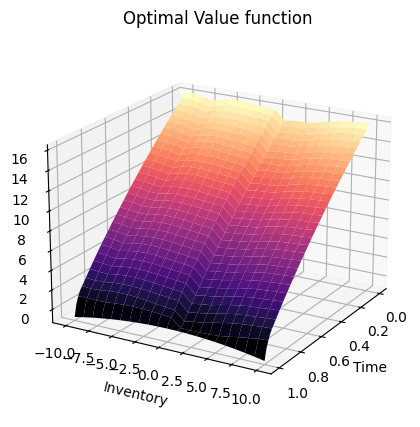

In [14]:
# Plot the value function
Y = value_function.q_grid
X = value_function.t_grid
X, Y = np.meshgrid(X, Y)


f = plt.figure(figsize=[5, 5])
pp3d = plt.axes(projection="3d", elev=20, azim=30)
pp3d.set_title("Optimal Value function")
pp3d.set_xlabel("Time")
pp3d.set_ylabel("Inventory")
pp3d.set_zlabel("Optimal Value")
pp3d.plot_surface(X, Y, value_function.h, cmap='magma')


plt.show()

As time progresses, the value function consistently decreases, reflecting the diminishing profitability and or increased risk associated with holding positions over time. With respect to inventory, the function remains relatively constant initially, indicating a balanced risk-return profile. However, as the time approaches its terminal value (near 1), the function becomes more pronounced as a negative quadratic with inventory, this is likeley due to our definition of our terminal inventory value.